In [306]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
import os, shutil

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

import soundscapy as ssp

from argparse import Namespace

In [308]:
from utils import *
from pca import CustomPCA
from fa import CustomFactorAnalysis as CustomFA

In [309]:
HOME = os.getcwd()
DATA = os.path.join(HOME, '..', 'data')
calib_mode = 'hats'

df = load_data(DATA, calib_mode)

In [310]:
len(df.pid.unique())

25

In [311]:
sns.set_theme('paper', 'whitegrid')

In [312]:
p1df = pd.read_csv('../data/p1tha.csv').set_index('PAQ')

## Reliability Check

In [313]:
import pingouin as pg

In [314]:
def define_latex_command(name, value, value_format=None):
    
    if value_format is not None:
        if type(value_format) is str:
            value = value_format.format(value)
        else:
            value = value_format(value)
    
    nc = "\\newcommand{\\" + name + "}{" + value + "}"
    
    return nc

In [315]:
tab = []

iccs = {}

for p in PAQ_CCW:
    
    cols = []
    alph, ci = pg.cronbach_alpha(df, subject='pid', items='stimulus_id', scores=p)
    ic = pg.intraclass_corr(df, raters='pid', ratings=p, targets='stimulus_id').set_index('Type')
    
    
    cols += [
        f"tha{p.capitalize()}",
        # f"{alph:.3f}",
        # f"[{ci[0]:.3f}, {ci[1]:.3f}]",
        f"{ic.loc['ICC2']['ICC']:.3f}",
        f"[{ic.loc['ICC2']['CI95%'][0]:.3f}, {ic.loc['ICC2']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2']['F']:.3f}",
        f"$<$0.001",
        f"{ic.loc['ICC2k']['ICC']:.3f}",
        f"[{ic.loc['ICC2k']['CI95%'][0]:.3f}, {ic.loc['ICC2']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2k']['F']:.3f}",
        f"$<$0.001",
    ]
    tab.append(" & ".join(cols))
    # print(define_latex_command(f"cronbach{p.capitalize()}", alph, "{:.3g}"))

    # print(define_latex_command(f"cronbach{p.capitalize()}cilo", ci[0], "{:.3g}"))
    # print(define_latex_command(f"cronbach{p.capitalize()}cihi", ci[1], "{:.3g}"))
    
    iccs[p] = [ic.loc['ICC2']['ICC'], ic.loc['ICC2k']['ICC']]
    
print("\\\\ \n".join(tab) + "\\\\")

thaPl & 0.571 & [0.440, 0.720] & 42.341 & $<$0.001 & 0.971 & [0.950, 0.720] & 42.341 & $<$0.001\\ 
thaVi & 0.590 & [0.460, 0.730] & 41.750 & $<$0.001 & 0.973 & [0.960, 0.730] & 41.750 & $<$0.001\\ 
thaEv & 0.252 & [0.160, 0.400] & 11.425 & $<$0.001 & 0.894 & [0.830, 0.400] & 11.425 & $<$0.001\\ 
thaCh & 0.571 & [0.440, 0.720] & 44.172 & $<$0.001 & 0.971 & [0.950, 0.720] & 44.172 & $<$0.001\\ 
thaAn & 0.547 & [0.420, 0.700] & 39.817 & $<$0.001 & 0.968 & [0.950, 0.700] & 39.817 & $<$0.001\\ 
thaMo & 0.412 & [0.290, 0.580] & 20.235 & $<$0.001 & 0.946 & [0.910, 0.580] & 20.235 & $<$0.001\\ 
thaUn & 0.256 & [0.160, 0.410] & 11.186 & $<$0.001 & 0.896 & [0.830, 0.410] & 11.186 & $<$0.001\\ 
thaCa & 0.593 & [0.460, 0.740] & 47.907 & $<$0.001 & 0.973 & [0.960, 0.740] & 47.907 & $<$0.001\\


In [316]:
ic

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.591752,37.237223,26,648,1.952284e-110,"[0.47, 0.74]"
ICC2,Single random raters,0.593231,47.906685,26,624,3.651714e-130,"[0.46, 0.74]"
ICC3,Single fixed raters,0.652327,47.906685,26,624,3.651714e-130,"[0.53, 0.78]"
ICC1k,Average raters absolute,0.973145,37.237223,26,648,1.952284e-110,"[0.96, 0.99]"
ICC2k,Average random raters,0.973305,47.906685,26,624,3.651714e-130,"[0.96, 0.99]"
ICC3k,Average fixed raters,0.979126,47.906685,26,624,3.651714e-130,"[0.97, 0.99]"


In [317]:
for p, (icc2, icc2k) in iccs.items():
    p1df.loc[p, 'ICC2'] = icc2
    p1df.loc[p, 'ICC2k'] = icc2k
    

In [318]:
p1df['isMain'] = p1df.index.isin(['pl', 'an', 'ev', 'un'])

In [319]:
def get_lim(y):
    return max(np.floor(y.min()*20 - 1)/20, 0.0), min(1.0, np.ceil(y.max()*20 + 1)/20)


def p1vsp2(crit):

    f, ax = plt.subplots(figsize=(5,3), tight_layout=True)
    ax2 = ax.twinx()

    # crit = "APPR"

    sns.scatterplot(p1df, x=crit,y='ICC2', marker='s', c='b', ax=ax, label='ICC(2,1)', legend=None, ec="none")
    # ax.set(ylim=[0.2, 0.65])
    ax.set(ylim=get_lim(p1df["ICC2"]))
    sns.scatterplot(p1df, x=crit,y='ICC2k', marker='^', c='r', ax=ax2, label='ICC(2,k)', legend=None, ec="none")
    # ax2.set(ylim=[0.88, 0.98])
    ax2.set(ylim=get_lim(p1df["ICC2k"]))

    for p in ['ev', 'mo', 'un']:
        ax.text(x=p1df.loc[p, crit], y=p1df.loc[p, 'ICC2'] - 0.02, s=f"tha{p.capitalize()}", ha='center', va='top')

    nticks = 11
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(nticks))
    ax2.yaxis.set_major_locator(mpl.ticker.LinearLocator(nticks))
    # ax2.grid(False)

    ax2.figure.legend(loc='upper left', bbox_to_anchor=(0.125, 0.925))

    ax.set(xlabel=f'{crit} (Stage 1)')
    ax.set(ylabel='ICC(2,1)')
    ax2.set(ylabel='ICC(2,k)')


    plt.savefig(f'figs/{crit}_vs_icc.pdf')
    plt.show()

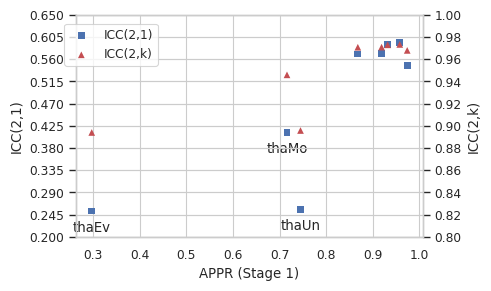

In [320]:
for crit in ['APPR']:
    p1vsp2(crit)

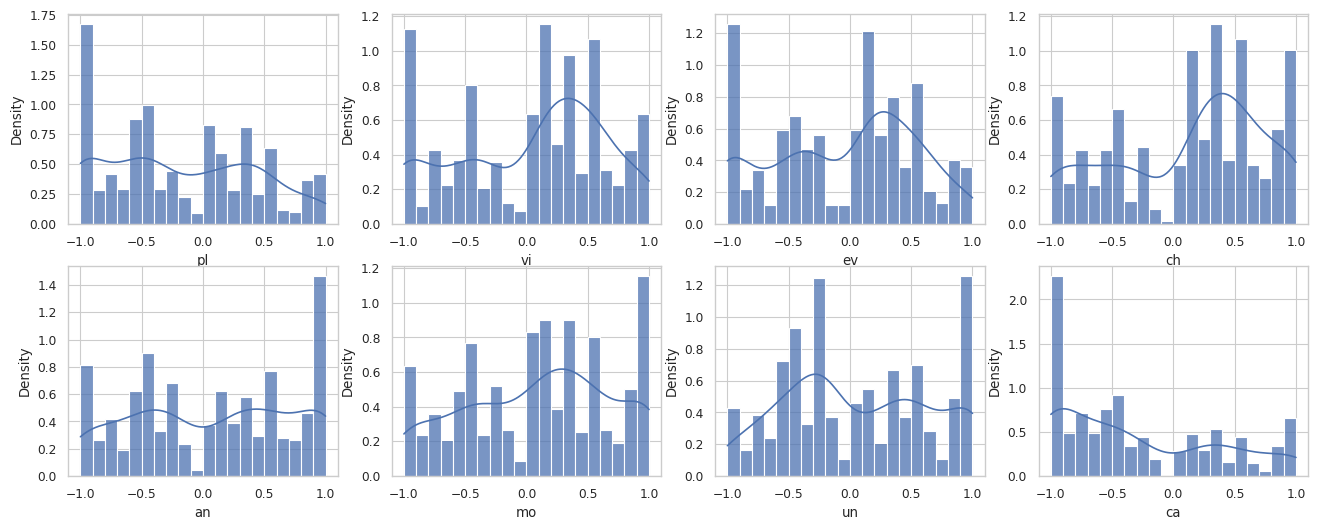

In [321]:
f, axs = plt.subplots(2, 4, figsize=(16, 6), sharex=False)

for i in range(8):
    cax = axs[i//4, i%4]
    sns.histplot(df, x=PAQ_CCW[i], bins=20, stat='density', ax=cax)
    sns.kdeplot(df, x=PAQ_CCW[i], ax=cax, clip=[-1,1])

# ISO

In [322]:
def stim2filename(s):
    fnames = ['CG01', 'CG04', 'CT301', 'E01b', 'E02', 'E05', 'E09', 'CG07', 'E11b', 'E12b', 'E10', 'HR01', 'KT01', 'LS06', 'N1', 'OS01c', 'OS01d', 'RPJ01', 'VP01b', 'W01', 'W06', 'W09', 'W11a', 'W15', 'W16', 'W22', 'W23a']
    return fnames[int(s)-1]

df['Recording'] = df['stimulus_id'].apply(stim2filename)

In [323]:
dfeng = pd.read_excel("../data/engUCL-paq.xlsx")[["Participant", "Recording"] + PAQ_CCW]

for col in PAQ_CCW:
    dfeng[col] = dfeng[col].apply(normalize_response) #.apply(double_square)
        
dfeng['isopl'] = dfeng.apply(iso_pl, axis=1).apply(norm_norm)
dfeng['isoev'] = dfeng.apply(iso_ev, axis=1).apply(norm_norm)

dfengx = dfeng.groupby("Recording").mean().sort_index()

In [426]:
from matplotlib.patches import Circle

In [1]:
n = 2**12

xx = np.meshgrid(*[np.linspace(-1, 1, 4) for _ in range(8)])
xx = np.stack(xx)
xx = xx.reshape(8, -1)
print(xx.shape)

x = np.zeros((xx.shape[-1], 2))

for i in range(xx.shape[-1]):
    x0 = arr_to_ns(xx[:, i])
    x[i, 0] = norm_norm(iso_pl(x0))
    x[i, 1] = norm_norm(iso_ev(x0))
    
f, ax = plt.subplots()
ax.scatter(x[:, 0], x[:, 1])

k = 2/(2 + np.sqrt(8))

x, y = np.meshgrid([-1, -k, 0, k, 1], [-1, -k, 0, k, 1])

ax.plot([1, k, -k, -1], [k, 1, 1, k], c='red')

ax.set_aspect('equal')
circ = Circle((0, 0), 1, fc="none", ls=":", ec="gray")
ax.add_patch(circ)

NameError: name 'np' is not defined

In [469]:
y

[array([[-1.        , -1.41421356,  0.        ,  1.41421356,  1.        ],
        [-1.        , -1.41421356,  0.        ,  1.41421356,  1.        ],
        [-1.        , -1.41421356,  0.        ,  1.41421356,  1.        ],
        [-1.        , -1.41421356,  0.        ,  1.41421356,  1.        ],
        [-1.        , -1.41421356,  0.        ,  1.41421356,  1.        ]]),
 array([[-1.        , -1.        , -1.        , -1.        , -1.        ],
        [-1.41421356, -1.41421356, -1.41421356, -1.41421356, -1.41421356],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.41421356,  1.41421356,  1.41421356,  1.41421356,  1.41421356],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])]

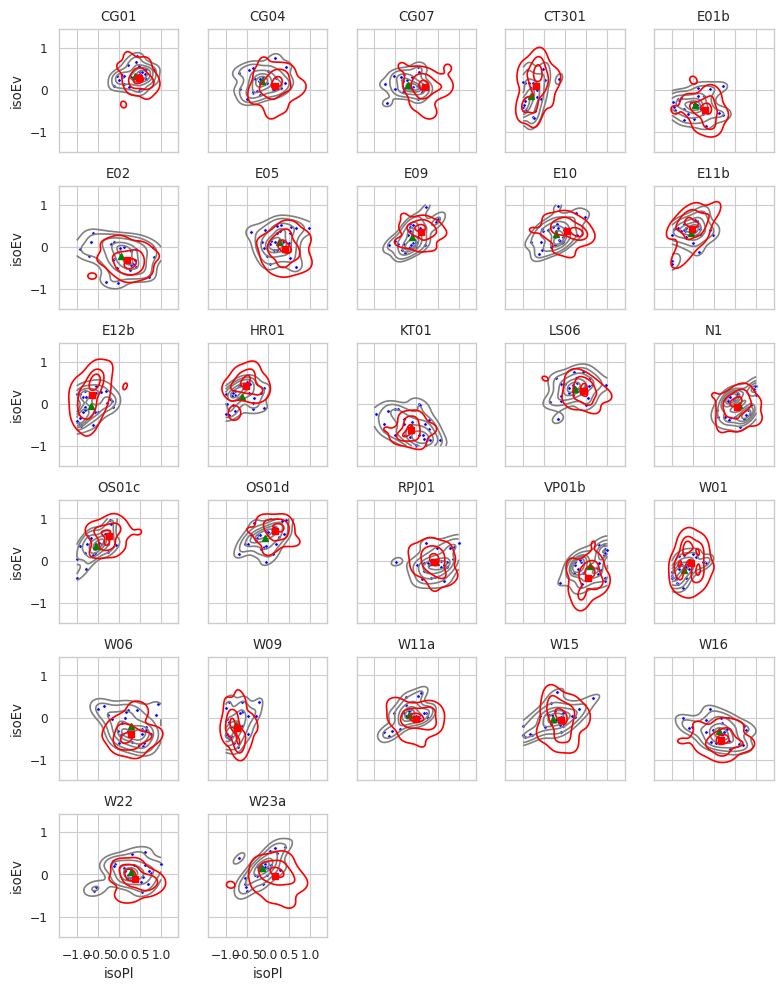

In [488]:
import math

ncol = 5
nrow = math.ceil(27 / ncol)

f, axs = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True, tight_layout=True)
for i in range(3):
    f.delaxes(axs[-1][-(i+1)])
    
for i, (s, dfg) in enumerate(df.groupby('Recording')):
    
    r = i // ncol
    c = i % ncol
    axs[r, c].set_title(s)
    axs[r, c].set_aspect('equal')
    sns.kdeplot(dfg, x='isopl', y='isoev', levels=[0.1, 0.25, 0.5, 0.75, 0.9], ax=axs[r,c], color="gray", clip=(-1,1))
    sns.scatterplot(dfg, x='isopl', y='isoev', ax=axs[r,c], color="blue", marker='.')
    # sns.scatterplot(, x='isopl', y='isoev', ax=axs[r,c], color="blue", marker='o')
    x, y = dfg[['isopl', 'isoev']].mean().values
    axs[r,c].plot(x, y, color="green", marker='^', label='Thai')
    
    x, y = dfeng[dfeng.Recording == s][['isopl', 'isoev']].mean().values
    axs[r,c].plot(x, y, color="red", marker='s', label='Eng')
    
    
    
#     circ = Circle((0, 0), 1, fc="none", ls=":", ec="gray")
#     axs[r,c].add_patch(circ)
    
    # print()
    
    axs[r, c].set(xlabel="isoPl", ylabel="isoEv", xticks=np.linspace(-1, 1, 5))
    
    sns.kdeplot(dfeng[dfeng.Recording == s], x='isopl', y='isoev', levels=[0.1, 0.5, 0.9], ax=axs[r,c], color="red")
    # sns.scatterplot(dfg, x='isopl', y='isoev', ax=axs[r,c], color="blue", marker='.')
    
plt.savefig("perstim.pdf", dpi=600)

# PCA

In [325]:
from copy import deepcopy

In [326]:
def unitary_transform(pca, targets_proj):
    rpca = deepcopy(pca)

    A = rpca.components_[:2, :] @ targets_proj
    B = np.eye(2, 2)  
    M = B @ A.T
    U, S, Vt = np.linalg.svd(M)

    R = U@Vt

    rpca.components_[:2, :] = R @ rpca.components_[:2, :]
    
    return rpca, R

In [327]:
dfx = df.groupby('stimulus_id').mean()    
pca_raw = CustomPCA(n_components=8, whiten=False, center=False)
pca_mean = CustomPCA(n_components=8, whiten=False, center=False)

pca_raw = pca_raw.fit(df[PAQ_CCW])
pca_mean = pca_mean.fit(dfx[PAQ_CCW])

rpca_raw, Rr = unitary_transform(pca_raw, iso_proj)
rpca_mean, Rm = unitary_transform(pca_mean, iso_proj)

for n, pca in [('ur', pca_raw), ('um', pca_mean), ('rr', rpca_raw), ('rm', rpca_mean)]:
    pcm = pca.transform(dfx[PAQ_CCW])
    pcr = pca.transform(df[PAQ_CCW])
    for i in range(pca.n_components):
        dfx[f'{n}{i+1}proj'] = pcm[:, i]
        df[f'{n}{i+1}proj'] = pcr[:, i]

In [328]:
def cosine_sim(A, B, feature_axis=-1):
    A = A/np.linalg.norm(A, axis=feature_axis, keepdims=True)
    B = B/np.linalg.norm(B, axis=feature_axis, keepdims=True)
    
    C = np.sum(A*B, axis=feature_axis)
    
    return C

cosine_sim(rpca_raw.components_, rpca_mean.components_)

array([ 0.99805677,  0.96165094,  0.78755704, -0.76499166,  0.66373858,
        0.7740638 ,  0.86821296,  0.98514682])

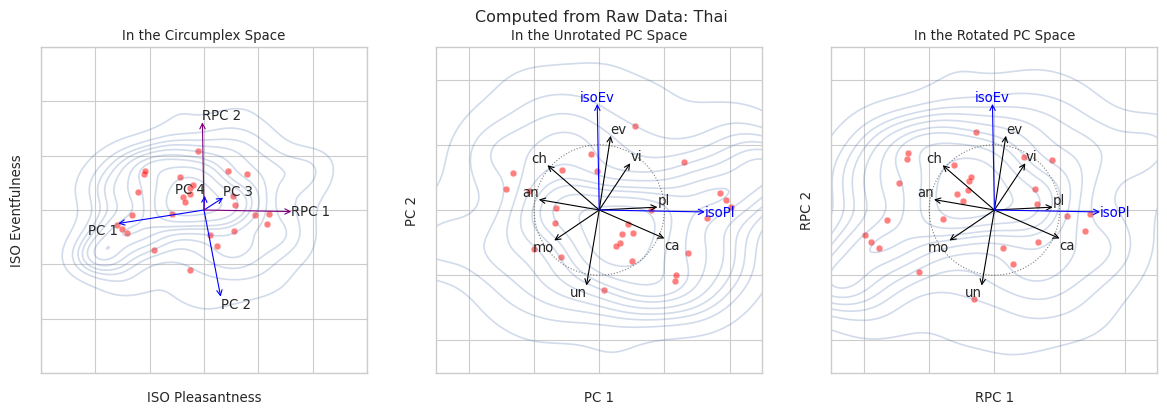

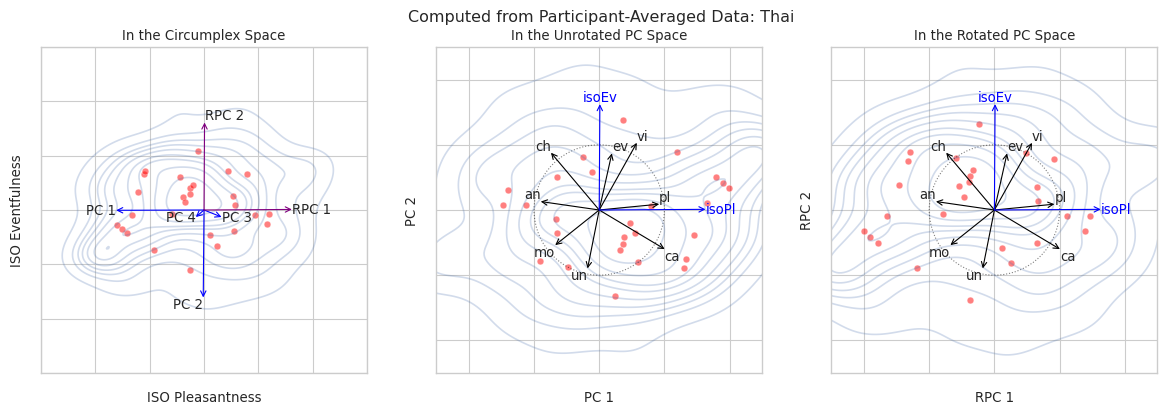

In [329]:
def make_pca_plot(pca, rpca, name, lang='tha'):
    
    def plot_in_pc(ax, x, y):
        sns.kdeplot(df, x=x, y=y, levels=10, alpha=0.25, ax=ax)
        sns.scatterplot(dfx, x=x, y=y, marker="o", c="red", alpha=0.5,  ax=ax)

        rdirections = {}
        for i, p in enumerate(PAQ_CCW):
            dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
            rdirections[p] = rpca.transform(dfi)[0, :2]

        r = np.mean([np.linalg.norm(d) for d in rdirections.values()])

        rdirections = {k: v/r for k, v in rdirections.items()}

        isopl_in_rpc = norm_norm(iso_pl(Namespace(**rdirections))) 
        isoev_in_rpc = norm_norm(iso_ev(Namespace(**rdirections))) 
        riso_plev = [isopl_in_rpc, isoev_in_rpc]

        k = 1.0

        for paq, d in rdirections.items():
            # d *= 2
            ax.annotate("", xy=k*d, xytext=(0, 0),
                    arrowprops=dict(arrowstyle="->", ec="black", shrinkA=0, shrinkB=0))
            ax.annotate(paq, xy=k*d, **hava(d, hd="center"))

        for i, p in enumerate(["isoPl", "isoEv"]):
            ax.annotate("", xy=2*k*riso_plev[i], xytext=(0, 0),
                    arrowprops=dict(arrowstyle="->", color="blue", shrinkA=0, shrinkB=0))
            ax.annotate(p, xy=2*k*riso_plev[i], **hava(riso_plev[i], vd="center", hd="center"), color="blue")


        c = plt.Circle((0, 0), 1.0, fc="none", ec="black", ls=":", alpha=0.5)

        ax.add_artist(c)

        lim = 2.5
        ax.axis('scaled')
        ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

    
    mode = name[0]
    
    if mode == 'r':
        suffix = f"Computed from Raw Data: {lang}"
    else:
        suffix = f"Computed from Participant-Averaged Data: {lang}"
        
    
    
    colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
    cmap = mpl.colors.ListedColormap(colors)

    f, axs = plt.subplots(1, 3, figsize=(12,4))
    

    ax = axs[0]

    lim = 1.5

    sns.kdeplot(df, x='isopl', y='isoev', levels=10, alpha=0.25, ax=ax)
    sns.scatterplot(dfx, x='isopl', y='isoev', marker="o", c="red", alpha=0.5, ax=ax)

    pc_in_std = pca.inverse_transform(np.stack([pc_vec(i) for i in range(pca.n_components)], axis=1))[:4]
    pc_in_iso = [norm_norm(iso_np(p)) for p in pc_in_std]

    rpc_in_std = rpca.inverse_transform(np.stack([pc_vec(i) for i in range(pca.n_components)], axis=1))[:2]
    rpc_in_iso = [norm_norm(iso_np(p)) for p in rpc_in_std]

    k = 2.0

    for i, v in enumerate(pc_in_iso):
        ax.annotate("", xy=k*v, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", 
                                ec="blue",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

        # if i < 2:
        ax.annotate(f"PC {i+1}", xy=k*v, **hava(v, thresh=0.05, hd="right", vd="center"))

    for i, v in enumerate(rpc_in_iso[:2]):
        ax.annotate("", xy=k*v, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", 
                                ec="purple",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

        ax.annotate(f"RPC {i+1}", xy=k*v, **hava(v, hd="left", vd="center"))

    ax.set(
        title=f'In the Circumplex Space', 
        xlabel="ISO Pleasantness",
        ylabel="ISO Eventfulness",
    )

    ax.axis('scaled')
    ax.set(xlim=[-lim, lim], ylim=[-lim, lim], xticklabels=[], yticklabels=[])

    ############################################

    ax = axs[1]

    x = f"u{mode}1proj"
    y = f"u{mode}2proj"
    
    plot_in_pc(ax, x, y)

    ax.set(
        title=f"In the Unrotated PC Space",
        xlabel="PC 1",
        ylabel="PC 2"
    )

    ############################################

    ax = axs[2]

    x = f"r{mode}1proj"
    y = f"r{mode}2proj"
    
    plot_in_pc(ax, x, y)

    
    ax.set(
        title=f"In the Rotated PC Space",
        xlabel="RPC 1",
        ylabel="RPC 2"
    )

   
    plt.suptitle(suffix, x=0.515, ha='center')

    plt.tight_layout()
    plt.savefig(f"figs/pca-{name}-{lang}.pdf")

    plt.show()
    
make_pca_plot(pca_raw, rpca_raw, 'raw', 'Thai')
make_pca_plot(pca_mean, rpca_mean, 'mean', 'Thai')

In [330]:
def get_rdirections(rpca):

    rdirections = {}
    rvec= {}
    for i, p in enumerate(PAQ_CCW):
        dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
        rvec[p] = rpca.transform(dfi)[0, :2]
        x, y = rvec[p]
        rdirections[p] = np.rad2deg(np.arctan2(y, x))
        
#     x, y = norm_norm(iso_pl(Namespace(**rvec))) 
#     rdirections['isopl'] = np.rad2deg(np.arctan2(y, x))
    
#     x, y = norm_norm(iso_ev(Namespace(**rvec))) 
#     rdirections['isoev'] = np.rad2deg(np.arctan2(y, x))
    
        
    return rdirections

In [331]:
# only use rpca_mean from now

pca = rpca_mean

In [332]:
fulldir = {}
for i, p in enumerate(PAQ_CCW):
    dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
    fulldir[p] = pca.transform(dfi)[0, :]

isopl_in_pc = norm_norm(iso_pl(Namespace(**fulldir)))
isoev_in_pc = norm_norm(iso_ev(Namespace(**fulldir)))

fulldir['isopl'] = isopl_in_pc
fulldir['isoev'] = isoev_in_pc

# fulldir

In [333]:
dfeng = pd.read_excel("../data/eng UCL.xlsx")

PAQs = [f"PAQ{i+1}" for i in range(8)]
dfeng = dfeng[["Participant", "Recording"] + PAQs]

dfeng = dfeng.rename(columns={
    f"PAQ{i+1}": p for i, p in enumerate(PAQ_CCW)
})

for col in PAQ_CCW:
    dfeng[col] = dfeng[col].apply(normalize_response) #.apply(double_square)
        
dfeng['isopl'] = dfeng.apply(iso_pl, axis=1).apply(norm_norm)
dfeng['isoev'] = dfeng.apply(iso_ev, axis=1).apply(norm_norm)

dfengx = dfeng.groupby("Recording").mean().sort_index()

In [334]:
pca_eng = CustomPCA(n_components=8, whiten=False, center=False)
pca_eng = pca_mean.fit(dfengx[PAQ_CCW])

rpca_eng, Rm = unitary_transform(pca_eng, iso_proj)

for n, pca in [('rm', rpca_eng)]:
    pcm = pca.transform(dfengx[PAQ_CCW])
    pcr = pca.transform(dfeng[PAQ_CCW])
    for i in range(pca.n_components):
        dfengx[f'{n}{i+1}proj'] = pcm[:, i]
        dfeng[f'{n}{i+1}proj'] = pcr[:, i]

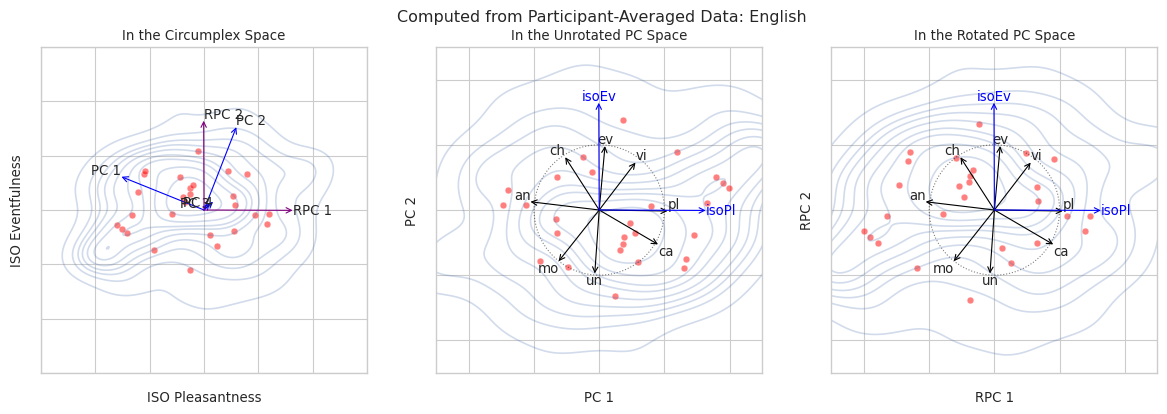

In [335]:
make_pca_plot(pca_eng, rpca_eng, 'mean', 'English')

In [336]:

tha = get_rdirections(rpca_mean)
eng = get_rdirections(rpca_eng)

tha = {f'tha{k.capitalize()}': v for k, v in tha.items()}
eng = {f'eng{k.capitalize()}': v for k, v in eng.items()}

thaIdx = pd.CategoricalDtype([f'tha{k.capitalize()}' for k in PAQ_CCW])
engIdx = pd.CategoricalDtype([f'eng{k.capitalize()}' for k in PAQ_CCW])

dfrs = []

for lang, idx in [(tha, thaIdx), (eng, engIdx)]:
    dfr = pd.DataFrame({'loc': lang})
    dfr.index = dfr.index.astype(idx)
    dfr = dfr.sort_index()
    dfr["theo"] = np.rad2deg(np.arctan2(iso_proj[:, 1], iso_proj[:, 0])).astype(int)
    langloc = dfr['loc'].values
    dfr['dev'] = dfr['loc'] - dfr['theo']
    dfr[f'adj-ccw'] = -np.mod(langloc - np.roll(langloc, -1), -360)
    dfr[f'adj-cw'] = np.mod(langloc - np.roll(langloc, 1), 360)
    
    # dfr[f'adj-bal'] = (np.roll(langloc, 1) + np.roll(langloc, -1))/ 2 - langloc
    
    dfr[f'orth-ccw'] = -np.mod(langloc - np.roll(langloc, -2), -360)
    dfr[f'orth-cw'] = np.mod(langloc - np.roll(langloc, 2), 360)
    dfr[f'anti'] = np.abs(langloc - np.roll(langloc, 4))
    dfr[f'anti'] = np.minimum(dfr[f'anti'], 360-dfr[f'anti'])
    
    dfrc = dfr.columns
    dfrc = ['theo'] + [c for c in dfrc if c != 'theo']
    
    
    dfrs.append(dfr[dfrc])
    
dfr = pd.concat(dfrs)

In [337]:
dfr

,theo,loc,dev,adj-ccw,adj-cw,orth-ccw,orth-cw,anti
thaPl,0,5.550125,5.550125,55.207718,36.410009,71.871333,106.813080,166.230156
thaVi,45,60.757843,15.757843,16.663615,55.207718,69.360382,91.617727,157.834002
thaEv,90,77.421458,-12.578542,52.696768,16.663615,94.358823,71.871333,178.684413
thaCh,135,130.118226,-4.881774,41.662055,52.696768,88.473620,69.360382,160.978109
thaAn,180,171.780281,-8.219719,46.811565,41.662055,86.956764,94.358823,166.230156
thaMo,-135,-141.408154,-6.408154,40.145199,46.811565,110.548271,88.473620,157.834002
thaUn,-90,-101.262955,-11.262955,70.403072,40.145199,106.813080,86.956764,178.684413
thaCa,-45,-30.859884,14.140116,36.410009,70.403072,91.617727,110.548271,160.978109
engPl,0,-0.833068,-0.833068,53.430467,29.512838,85.670761,93.159922,174.023510
engVi,45,52.597399,7.597399,32.240294,53.430467,70.223670,82.943305,179.006134


# Stat Tests


In [338]:
from scipy.stats import ttest_ind, mannwhitneyu as mwu

In [339]:
df[PAQ_CCW + ['stimulus_id', 'pid']].sort_values(['stimulus_id', 'pid'])

,pl,vi,ev,ch,an,mo,un,ca,stimulus_id,pid
0,0.60,0.60,1.00,0.00,-1.00,-1.00,-1.00,-1.00,1,2
1,0.40,0.20,0.20,0.20,-0.20,0.00,-0.20,0.00,1,3
2,0.78,0.78,0.26,-0.82,-0.58,-0.58,-0.84,0.10,1,4
3,0.32,0.28,0.28,0.32,0.20,-0.74,-0.20,-0.38,1,5
4,0.40,0.20,0.20,0.40,0.20,0.40,0.20,-0.40,1,6
...,...,...,...,...,...,...,...,...,...,...
670,0.50,0.50,0.20,-0.20,-0.30,0.00,-0.20,0.20,27,23
671,-0.14,0.22,-0.18,0.44,0.44,0.46,0.40,-0.52,27,24
672,0.00,0.40,0.20,0.20,-0.20,-0.20,-0.20,-0.20,27,25
673,0.42,0.36,-0.20,0.24,0.40,-0.38,0.20,-0.56,27,26


In [340]:
tha = df[['isopl', 'isoev', 'Recording', 'pid']].sort_values(['Recording', 'pid']).values
tha = tha.reshape((27, len(df.pid.unique()), -1))[:, :, :-2].astype(float)

In [341]:
eng = dfeng[['isopl', 'isoev', 'Recording', 'Participant']].sort_values(['Recording', 'Participant']).values

eng = eng.reshape((27, len(dfeng.Participant.unique()), -1))[:, :, :-2].astype(float)

In [342]:
mwu_res = mwu(tha, eng, axis=1)

In [504]:
dfm = pd.DataFrame(t_res.pvalue)
dfm.index = df.Recording.unique()
dfm.columns = ['pl/p', 'ev/p']

dfm['pl/ns'] = dfm['pl/p'] > 0.05
dfm['ev/ns'] = dfm['ev/p'] > 0.05

dfm

,pl/p,ev/p,pl/ns,ev/ns
CG01,1.827101e-01,0.295936,True,True
CG04,1.956520e-04,0.118143,False,True
CT301,1.381382e-07,0.419677,False,True
E01b,4.785472e-02,0.018042,False,False
E02,6.497331e-03,0.091468,False,True
E05,2.077780e-01,0.197363,True,True
E09,7.352698e-02,0.019525,True,False
CG07,4.930219e-03,0.055836,False,True
E11b,2.301736e-03,0.292334,False,True
E12b,7.223203e-01,0.184732,True,True


In [343]:
t_res = ttest_ind(tha, eng, axis=1, equal_var=False)

In [344]:
dfx['Recording'] = dfx.index.to_series().apply(stim2filename)
dfx = dfx.set_index('Recording')

## Comparison to Eng

In [345]:
from adjustText import adjust_text

In [346]:
diffx = (dfx - dfengx)

In [347]:
center = diffx[PAQ_CCW].mean()

In [348]:
dfc = df.copy()
dfc[PAQ_CCW] -= center

dfc['isopl'] = dfc.apply(iso_pl, axis=1).apply(norm_norm)
dfc['isoev'] = dfc.apply(iso_ev, axis=1).apply(norm_norm)

dfcx = dfc.groupby('stimulus_id').mean()    
pca_mean = CustomPCA(n_components=8, whiten=False, center=False)
pca_mean = pca_mean.fit(dfcx[PAQ_CCW])

rpca_mean, Rm = unitary_transform(pca_mean, iso_proj)

for n, pca in [('rm', rpca_mean)]:
    pcm = pca.transform(dfcx[PAQ_CCW])
    pcr = pca.transform(dfc[PAQ_CCW])
    for i in range(pca.n_components):
        dfcx[f'{n}{i+1}proj'] = pcm[:, i]
        dfc[f'{n}{i+1}proj'] = pcr[:, i]
        
dfcx['Recording'] = dfcx.index.to_series().apply(stim2filename)
dfcx = dfcx.set_index('Recording')

In [349]:
dfeng['isoplx'] = dfeng['isopl']
dfeng['isoevx'] = dfeng['isoev']
dfengx['isoplx'] = dfengx['isopl']
dfengx['isoevx'] = dfengx['isoev']

In [350]:
df['isoplx'] = df['isopl']
df['isoevx'] = df['isoev']
dfx['isoplx'] = dfx['isopl']
dfx['isoevx'] = dfx['isoev']

In [351]:
dfc['isoplx'] = dfc['isopl']
dfc['isoevx'] = dfc['isoev']
dfcx['isoplx'] = dfcx['isopl']
dfcx['isoevx'] = dfcx['isoev']

In [399]:
tha = dfx[['isopl', 'isoev']]
eng = dfengx[['isopl', 'isoev']]

In [353]:
u, s, vh = np.linalg.svd(eng.values.T @ tha.values)

In [354]:
rot = u @ vh

In [366]:
np.array(
            [[np.cos(theta_), np.sin(theta_)],
            [-np.sin(theta_), np.cos(theta_)]]
    )[:, :, 0]

array([[ 0.99370927,  0.11199056],
       [-0.11199056,  0.99370927]])

In [355]:
from scipy.optimize import minimize

In [421]:
theta = np.random.randn(6,)

def project(x, v):
    theta_ = x[:4]
    b = x[4:]
    
    # r = np.array(
    #     [
    #         [np.cos(theta_), np.sin(theta_)],
    #         [-np.sin(theta_), np.cos(theta_)]
    #     ]
    # )
    r = theta_.reshape((2, 2))
    return (v ) @ r - b[None, :]

def func(x):
    return np.sum(np.square(project(x, tha.values) - eng.values))

x = minimize(func, theta).x

In [422]:
dfx[['isoplx', 'isoevx']] = project(x, tha.values)

In [423]:
print(np.sum(np.square(dfx[['isoplx', 'isoevx']].values - eng.values)))
print(np.sum(np.square(dfx[['isopl', 'isoev']].values - eng.values)))

2.3909151422100052
3.9131316774934612


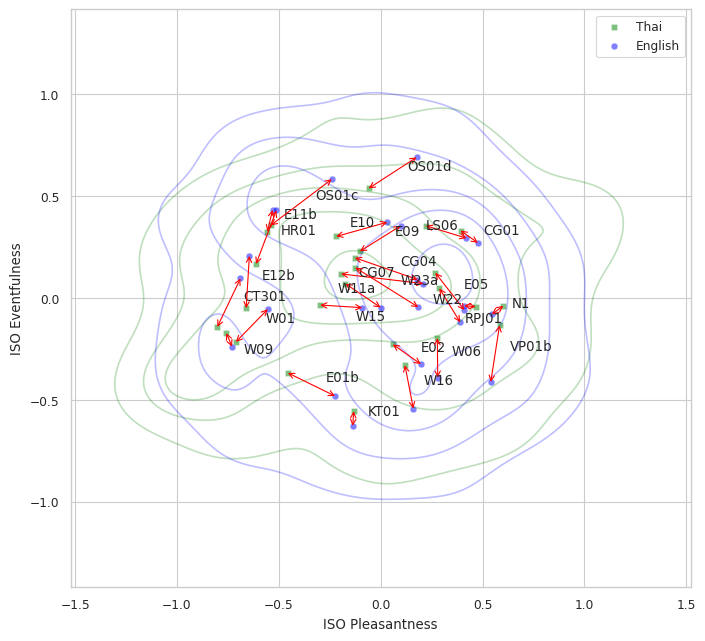

In [489]:
colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
cmap = mpl.colors.ListedColormap(colors)

f, ax = plt.subplots(1, 1, figsize=(8,8))

lim = 1

levels = [0.05, 0.25, 0.5, 0.75, 0.95]

x = 'isopl'
y = 'isoev'

sns.kdeplot(df, x=x, y=y, color="green", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfx, x=x, y=y, marker="s", c="green", alpha=0.5, ax=ax, label='Thai')

# sns.kdeplot(df, x=x, y=y, color="green", levels=levels, alpha=0.25, ax=ax)
# sns.scatterplot(dfx, x='isopl', y='isoev', marker="s", c="red", alpha=0.5, ax=ax, label='Old Thai')

sns.kdeplot(dfeng, x=x, y=y, color="blue", levels=levels, alpha=0.25, ax=ax)
sns.scatterplot(dfengx, x=x, y=y, marker="o", c="blue", alpha=0.5, ax=ax, label='English')

texts = []

for r in dfengx.index:
    # ax.annotate("", xytext=(dfx.loc[r, 'isopl'], dfx.loc[r, 'isoev']), 
    #             xy=(dfengx.loc[r, x], dfengx.loc[r, y]),
    #             arrowprops=dict(arrowstyle="->", 
    #                             ec="purple",
    #                             alpha=1.0, shrinkA=0, shrinkB=0
    #                            ))
    
    ax.annotate("", xytext=(dfx.loc[r, x], dfx.loc[r, y]), 
                xy=(dfengx.loc[r, x], dfengx.loc[r, y]),
                arrowprops=dict(arrowstyle="<->", 
                                ec="red",
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))
    
    # ax.annotate("", xytext=(dfx.loc[r, 'isopl'], dfx.loc[r, 'isoev']), 
    #             xy=(dfx.loc[r, x], dfx.loc[r, y]),
    #             arrowprops=dict(arrowstyle="->", 
    #                             ec="red",
    #                             alpha=1.0, shrinkA=0, shrinkB=0
    #                            ))
    
    texts.append(
        ax.text(x=(dfcx.loc[r, x] + dfengx.loc[r, x])/2, y=(dfcx.loc[r, y] + dfengx.loc[r, y])/2, s=r, ha='center', va='bottom')
    )
    
adjust_text(texts)

ax.set(
    # title=f'In the Circumplex Space', 
    xlabel="ISO Pleasantness",
    ylabel="ISO Eventfulness",
)

ax.axis('scaled')
# ax.set(xlim=[-lim, lim], ylim=[-lim, lim])#, xticklabels=[], yticklabels=[])

plt.show()